In [1]:
import os
import scipy.io as scio
import scipy.optimize as scop
import numpy as np
import pandas as pd
import scipy.linalg as slin
import matplotlib.pyplot as plt
from math import *

#### 1. Загрузите данные ex4data1.mat из файла.

In [2]:
data = scio.loadmat('data/Lab 4/ex4data1.mat')
X = data['X']
y = data['y'][:, 0]
m = np.shape(X)[0]

# 20x20 Input Images of Digits
input_layer_size = 400
# 25 hidden units
hidden_layer_size = 25
# 10 labels, from 1 to 10, note that 0 => 10
num_labels = 10

#### 2. Загрузите веса нейронной сети из файла ex4weights.mat, который содержит две матрицы Θ(1) (25, 401) и Θ(2) (10, 26). Какова структура полученной нейронной сети?

In [3]:
params = scio.loadmat('data/Lab 4/ex4weights.mat')
theta1 = params['Theta1']  # 25x401
theta2 = params['Theta2']  # 10x26
nn_params = np.concatenate((theta1.flatten(), theta2.flatten()))

Полученная нейронная сеть имеет:
 - входной слой размером 401 (400 + 1 bias)
 - скрытый слой размером 26 (25 + 1 bias)
 - выходной слой размером 10 


#### 3. Реализуйте функцию прямого распространения с сигмоидом в качестве функции активации. 

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
def predict(theta1, theta2, X):
    m = np.size(X, 0)
    X = np.concatenate((np.ones((m, 1), dtype=float), X), axis=1)
    temp1 = sigmoid(X @ theta1.T)
    temp = np.concatenate((np.ones((m, 1), dtype=float), temp1), axis=1)
    temp2 = sigmoid(temp @ theta2.T)
    p = np.argmax(temp2, axis=1) + 1
    return p
    

#### 4. Вычислите процент правильных классификаций на обучающей выборке. Сравните полученный результат с логистической регрессией.

In [6]:
prediction = predict(theta1, theta2, X)
correct_predictions = 0

for i in range(len(prediction)):
    if prediction[i] == y[i]:
        correct_predictions += 1
        
print("Accuracy: ", correct_predictions / len(y) * 100)

Accuracy:  97.52


Процент правильных классификаций на обучающей выборке получился больше чем c логической регрессией:
- 95.16% - логическая регрессия;
- 97.52% - нейронная сеть.

#### 5. Перекодируйте исходные метки классов по схеме one-hot.

In [7]:
y_oh = pd.get_dummies(y)

#### 6. Реализуйте функцию стоимости для данной нейронной сети.
#### 7. Добавьте L2-регуляризацию в функцию стоимости.

In [8]:
def nn_cost_function(nn_params, input_layer_size,
                   hidden_layer_size, num_labels,
                   X, y, l):
    theta1 = nn_params[0:hidden_layer_size * (input_layer_size + 1)]
    theta1 = theta1.reshape((hidden_layer_size, input_layer_size + 1))
    theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):]
    theta2 = theta2.reshape((num_labels, hidden_layer_size + 1))
    m = np.shape(X)[0]

    a1 = np.concatenate((np.ones((m, 1), dtype=float), X), axis=1)
    z2 = a1 @ theta1.T
    a2 = np.concatenate((np.ones((m, 1)), sigmoid(z2)), axis=1)
    z3 = a2 @ theta2.T
    a3 = sigmoid(z3)
    p = np.zeros((m, num_labels), dtype=int)
    p[np.arange(m), y - 1] = 1
    j = np.sum(-p * np.log(a3) - (1 - p) * np.log(1 - a3)) / m

    reg = np.sum( np.sum(np.power(theta1[:, 1:], 2)) + np.sum(np.power(theta2[:, 1:], 2)) )

    j += l / (2 * m) * reg
    
    return j

#### 8. Реализуйте функцию вычисления производной для функции активации.

In [9]:
def sigmoid_gradient(z):
     return sigmoid(z) * (1 - sigmoid(z))

#### 9. Инициализируйте веса небольшими случайными числами.

In [10]:
def rand_initialize_weights(l_in, l_out):
    epsilon_init = 0.12
    w = np.random.rand(l_out, l_in + 1) * 2 * epsilon_init - epsilon_init
    return w

In [11]:
initial_theta1 = rand_initialize_weights(input_layer_size, hidden_layer_size)
initial_theta2 = rand_initialize_weights(hidden_layer_size, num_labels)
initial_nn_params = np.concatenate(
    (initial_theta1.flatten(), initial_theta2.flatten()))

#### 10. Реализуйте алгоритм обратного распространения ошибки для данной конфигурации сети.
#### 12. Добавьте L2-регуляризацию в процесс вычисления градиентов.

In [12]:
def nn_gradient(nn_params, input_layer_size,
                   hidden_layer_size, num_labels,
                   X, y, l):
    
    theta1 = nn_params[0:hidden_layer_size * (input_layer_size + 1)]
    theta1 = theta1.reshape((hidden_layer_size, input_layer_size + 1))
    theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):]
    theta2 = theta2.reshape((num_labels, hidden_layer_size + 1))
    m = np.shape(X)[0]

    # Forward propagation
    a1 = np.concatenate((np.ones((m, 1), dtype=float), X), axis=1)
    z2 = a1 @ theta1.T
    a2 = np.concatenate((np.ones((m, 1)), sigmoid(z2)), axis=1)
    z3 = a2 @ theta2.T
    a3 = sigmoid(z3)
    p = np.zeros((m, num_labels), dtype=int)
    p[np.arange(m), y - 1] = 1
    
    delta3 = a3 - p
    delta2 = delta3 @ theta2 * sigmoid_gradient(np.concatenate((np.ones((m, 1), dtype=float), z2), axis=1))
    theta2_grad = delta3.T @ a2
    theta1_grad = delta2[:, 1:].T @ a1

    theta1_grad = theta1_grad / m
    theta1_grad[:, 1:] = theta1_grad[:, 1:] + l / m * theta1[:, 1:]
    theta2_grad = theta2_grad / m
    theta2_grad[:, 1:] = theta2_grad[:, 1:] + l / m * theta2[:, 1:]
    
    grad = np.concatenate((theta1_grad.flatten(), theta2_grad.flatten()))
    return grad

#### 11. Для того, чтобы удостоверится в правильности вычисленных значений градиентов используйте метод проверки градиента с параметром ε = 10-4.

In [13]:
def compute_numerical_gradient(J, theta, args):
    numgrad = np.zeros(np.size(theta), dtype=float)
    perturb = np.zeros(np.size(theta), dtype=float)
    epsilon = 1e-4
    for i in range(np.size(theta)):
        perturb[i] = epsilon
        loss1 = J(theta - perturb, *args)
        loss2 = J(theta + perturb, *args)
        numgrad[i] = (loss2 - loss1) / (2 * epsilon)
        perturb[i] = 0
    return numgrad

In [14]:
def debug_initialize_weights(f_out, f_in):
    w = np.sin(np.arange(f_out * (f_in + 1)) + 1).reshape(f_out, f_in + 1) / 10
    return w

In [15]:
def check_NN_gradients(l):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    theta1 = debug_initialize_weights(hidden_layer_size, input_layer_size)
    theta2 = debug_initialize_weights(num_labels, hidden_layer_size)

    x = debug_initialize_weights(m, input_layer_size - 1)
    y = 1 + (np.arange(m) + 1) % num_labels

    nn_params = np.concatenate((theta1.flatten(), theta2.flatten()))

    grad = nn_gradient(nn_params, input_layer_size,
                      hidden_layer_size, num_labels, x, y, l)
    
    numgrad = compute_numerical_gradient(nn_cost_function, nn_params,
                                       (input_layer_size, hidden_layer_size, num_labels, x, y, l))
    print(numgrad, '\n', grad)    
    diff = slin.norm(numgrad - grad) / slin.norm(numgrad + grad)
    print('Relative Difference: ', diff)

#### 13. Проверьте полученные значения градиента.

In [16]:
check_NN_gradients(0)

[ 1.23162247e-02  1.73828185e-04  2.61455146e-04  1.08701450e-04
  3.92471369e-03  1.90101250e-04  2.22272334e-04  5.00872543e-05
 -8.08459407e-03  3.13170623e-05 -2.17840346e-05 -5.48569878e-05
 -1.26669105e-02 -1.56130209e-04 -2.45506164e-04 -1.09164882e-04
 -5.59342546e-03 -2.00036572e-04 -2.43630216e-04 -6.32313668e-05
  3.09347722e-01  1.61067138e-01  1.47036522e-01  1.58268577e-01
  1.57616707e-01  1.47236360e-01  1.08133003e-01  5.61633717e-02
  5.19510542e-02  5.47353405e-02  5.53082757e-02  5.17752619e-02
  1.06270372e-01  5.57611045e-02  5.05568118e-02  5.38805142e-02
  5.47407215e-02  5.02929547e-02] 
 [ 1.23162247e-02  1.73828184e-04  2.61455144e-04  1.08701450e-04
  3.92471369e-03  1.90101252e-04  2.22272331e-04  5.00872547e-05
 -8.08459407e-03  3.13170587e-05 -2.17840341e-05 -5.48569864e-05
 -1.26669105e-02 -1.56130210e-04 -2.45506163e-04 -1.09164881e-04
 -5.59342547e-03 -2.00036572e-04 -2.43630220e-04 -6.32313673e-05
  3.09347722e-01  1.61067138e-01  1.47036522e-01  1.58

Приведенные два столбца очень похожи. Это означает, что реализация обратного распространения сделана правильно
(относительная разница должна менее 1e-9)

#### 14. Обучите нейронную сеть с использованием градиентного спуска или других более эффективных методов оптимизации.

In [17]:
print('Training Neural Network... \n')

l = 2
param = scop.fmin_cg(nn_cost_function, initial_nn_params,
                     fprime=nn_gradient,
                     args=(input_layer_size, hidden_layer_size,
                           num_labels, X, y, l),
                     maxiter=50)

theta1 = param[0:hidden_layer_size * (input_layer_size + 1)]
theta1 = theta1.reshape(hidden_layer_size, input_layer_size + 1)
theta2 = param[hidden_layer_size * (input_layer_size + 1):]
theta2 = theta2.reshape(num_labels, hidden_layer_size + 1)

Training Neural Network... 

         Current function value: 0.567068
         Iterations: 50
         Function evaluations: 105
         Gradient evaluations: 105


#### 15. Вычислите процент правильных классификаций на обучающей выборке.

In [18]:
pred = predict(theta1, theta2, X)
print('Training Set Accuracy: ', np.mean(pred == y) * 100)

Training Set Accuracy:  96.04


#### 16. Визуализируйте скрытый слой обученной сети.

In [19]:
def display_data(X):
    m, n = np.shape(X)
    example_width = round(sqrt(n))
    example_height = int(n/ example_width)

    # Compute number of items to display
    display_rows = floor(sqrt(m))
    display_cols = ceil(m / display_rows)

    # Between images padding
    pad = 1

    # Setup blank display
    a = pad + display_rows * (example_height + pad)
    b = pad + display_cols * (example_width + pad)
    display_array = -np.ones((a, b), dtype=float)

    # Copy each example into a patch on the display array
    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex >= m:
                break
            max_val = max(abs(X[curr_ex, :]))
            i_1 = pad + j * (example_height + pad)
            i_2 = pad + i * (example_width + pad)
            display_array[i_1:i_1 + example_height, i_2:i_2 + example_width] = X[curr_ex, :].reshape(example_height, example_width) / max_val
            curr_ex += 1
        if curr_ex >= m:
                break
    plt.imshow(display_array.T, cmap='gray')
    plt.show()

Visualizing Neural Network ...


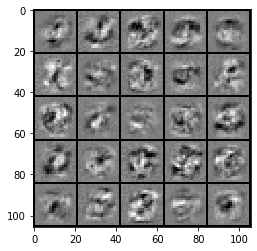

In [20]:
print('Visualizing Neural Network ...')
display_data(theta1[:, 1:])

#### 17. Подберите параметр регуляризации. Как меняются изображения на скрытом слое в зависимости от данного параметра?

При увеличении значения регуляризации изображения на скрытом слое становятся более размытыми.

Оптимальное значение регуляризации = 1-2, процент правильных классификаций в таком случае держится в районе 96%, 
далее начинает уменьшаться.
